# Proportional Odds Model

Fits a proporitional odds model to the mental impairment data.

In [1]:
library(data.table)
library(ggplot2)
library(MASS)
library(xtable)

mental.impairment <- data.table(read.csv('mental_impairment.csv', check.names=FALSE))
mental.impairment[,`Mental Impairment`:=factor(
    `Mental Impairment`,
    ordered=TRUE,
    c('Well', 'Mild', 'Moderate', 'Impaired'))]
mental.impairment

Subject,Mental Impairment,SES,Life Events
1,Well,1,1
2,Well,1,9
3,Well,1,4
4,Well,1,3
5,Well,0,2
6,Well,1,0
7,Well,0,1
8,Well,1,3
9,Well,1,3
10,Well,1,7


In [2]:
model.list <- lapply(list(`Mental Impairment` ~ 1,
                          `Mental Impairment` ~ 1 + SES,
                          `Mental Impairment` ~ 1 + `Life Events`,
                          `Mental Impairment` ~ 1 + SES + `Life Events`),
       polr, data=mental.impairment, method='logistic')

In [3]:
log.likelihood <- function(model, data) {
    probabilities = predict(model, data, type='probs')
    index <- t(sapply(data$`Mental Impairment`, function(x) { x == levels(x) }))
    sum(log(probabilities[index]))
}

model.summary <- data.frame(
    `$\\alpha_0$`=sapply(model.list, function(model) { model$zeta[1] }),
    `$\\alpha_1$`=sapply(model.list, function(model) { model$zeta[2] }),
    `$\\alpha_2$`=sapply(model.list, function(model) { model$zeta[3] }),
    `$\\beta_1$`=sapply(
        model.list,
        function(model) { if('SES' %in% names(model$coefficients)) model$coefficients['SES'] else NA }),
    `$\\beta_2$`=sapply(
        model.list,
        function(model) { if('`Life Events`' %in% names(model$coefficients)) model$coefficients['`Life Events`'] else NA }),
    `Log-likelihood`=sapply(
        model.list,
        function(model) { log.likelihood(model, mental.impairment) }),
    row.names=c('Equation \\ref{eqn:p7_model_1}',
                'Equation \\ref{eqn:p7_model_2}',
                'Equation \\ref{eqn:p7_model_3}',
                'Equation \\ref{eqn:p7_model_4}'),
    check.names=FALSE)

print(xtable(model.summary,
             caption='Results of fitting various models corresponding to each equation.',
             label='tab:p7_model_summary',
             digits=c(0, 3, 3, 3, 3, 3, 3)),
      booktabs=TRUE, file='p7_model_summary.tex',
      sanitize.colnames.function=identity,
      sanitize.rownames.function=identity)
                         
model.summary

,$\alpha_0$,$\alpha_1$,$\alpha_2$,$\beta_1$,$\beta_2$,Log-likelihood
Equation \ref{eqn:p7_model_1},-0.8472977,0.40545274,1.236750,NA,NA,-54.52103
Equation \ref{eqn:p7_model_2},-1.3637602,-0.04172851,0.830611,-0.8553378,NA,-53.43718
Equation \ref{eqn:p7_model_3},0.2614334,1.65627518,2.587626,NA,0.2879300,-51.26354
Equation \ref{eqn:p7_model_4},-0.2819031,1.21279257,2.209372,-1.1112310,0.3188613,-49.54895


In [4]:
# Set up hypotheses
likelihood.ratio.test <- data.frame(
    `Alternate Model`=c(2, 3, 4, 4, 4),
    `Null Model`=c(1, 1, 1, 2, 3),
    `Degrees of freedom`=c(1,1,2,1,1),
    check.names=FALSE)

# Statistical test
likelihood.ratio.test$Deviance <- apply(likelihood.ratio.test, MARGIN=1, FUN=function(hypothesis) {
    model.list[[hypothesis['Null Model']]]$deviance - model.list[[hypothesis['Alternate Model']]]$deviance
})
likelihood.ratio.test$`$p$-value` <- with(
    likelihood.ratio.test, pchisq(Deviance, df=`Degrees of freedom`, lower.tail=FALSE))

likelihood.ratio.test

Alternate Model,Null Model,Degrees of freedom,Deviance,$p$-value
2,1,1,2.167700,0.140936928
3,1,1,6.514977,0.010696971
4,1,2,9.944156,0.006928734
4,2,1,7.776457,0.005293151
4,3,1,3.429180,0.064053916


In [5]:
# Pretty print
likelihood.ratio.test$`Alternate Model` <- with(        
    likelihood.ratio.test, row.names(model.summary)[`Alternate Model`])
likelihood.ratio.test$`Null Model` <- with(
    likelihood.ratio.test, row.names(model.summary)[`Null Model`])

print(xtable(likelihood.ratio.test,
             caption='Likelihood ratio tests comparing the models in Table \\ref{tab:p7_model_summary}.',
             label='tab:p7_likelihood_ratio_test',
             digits=c(0, 0, 0, 0, 5, 5)),
      booktabs=TRUE, file='p7_likelihood_ratio_test.tex',
      include.rownames=FALSE,
      sanitize.colnames.function=identity,
      sanitize.text.function=identity)

In [6]:
probabilities <- with(mental.impairment, CJ(SES=sort(unique(SES)), `Life Events`=sort(unique(`Life Events`))))
probabilities <- cbind(probabilities, predict(model.list[[4]], probabilities, type='prob'))
probabilities <- with(
    mental.impairment,
    melt(probabilities, measure.vars=levels(`Mental Impairment`),
         variable.name='Mental Impairment', value.name='Probability'))

png 
  2

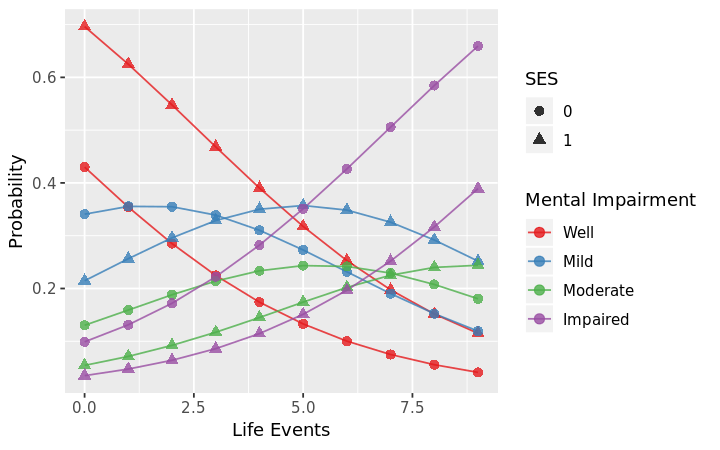

In [7]:
fig <- ggplot(probabilities, aes(x=`Life Events`, y=Probability, color=`Mental Impairment`)) +
  geom_line(aes(group=interaction(factor(SES), `Mental Impairment`)), alpha=0.8) + 
  geom_point(aes(shape=factor(SES)), size=2.5, alpha=0.8) +  
  scale_color_brewer('Mental Impairment', palette='Set1') +
  scale_shape_discrete('SES') +
  scale_x_continuous('Life Events')

pdf('p8_fitted_probabilities.pdf', width =6, height=3.75)
fig
dev.off()

options(repr.plot.width=6, repr.plot.height=3.75)
fig